# 2d parameter space exploration of the standard scheme

In [18]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# -------------------------------------------------------------------------------------------------------
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre + 'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dir_pre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirDataSCP = dir_pre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'  # Processed data directory
dirDataSNQ = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'  # Processed data directory

# Data

In [19]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dirDataSNQ)
SNQ = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

RiBulk_SNQ, _, _ = turbpy.bulkRichardson(SNQ.T6 + 273.15, SNQ.Tsrf + 273.15,SNQ.WIND, 6.)
SNQ['RiBulk'] = RiBulk_SNQ

# Indices of simulated turbulence times (observations exist and wind > 2m/s)
SNQind = np.nonzero((SNQ.WIND > .2).values & (~(np.isnan(SNQ.SensFlux)).values) & (SNQ.RiBulk > 0).values)
# Indices of simulated turbulence times (observations exist, wind > 2m/s, and snow is present)
SNQind_SP = np.nonzero((SNQ.SP == 1).values & (SNQ.WIND > 2).values &
                       (~(np.isnan(SNQ.SensFlux)).values))

# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dirDataSCP)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
SCP = xr.open_dataset('SCP.Mtower.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
SCP['w_tc__2m'] = fluxObs.w_tc__2m_M
SCP['w_tc_10m'] = fluxObs.w_tc__10m_M

# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.
Tsfc = (radObs.Rlw_out / sigma) ** (1 / 4)
SCP['Tsfc'] = (('time'), Tsfc - 273.15)

# Wind speed magnitude
SCP['UBar_15m'] = (('time'), (SCP.U_15m_M**2 + SCP.V_15m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_15m > 10] = np.nan
SCP['UBar_2m'] = (('time'), (SCP.u_2m_M**2 + SCP.v_2m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_2m > 10] = np.nan

# Bulk Richardson number
RiBulk_15m,_,_ = turbpy.bulkRichardson(SCP.T_15m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_15m, 15.)
SCP['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(SCP.T_1m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_2m, 2.)
SCP['RiBulk_2m'] = RiBulk_2m

# Indices of stable periods (simulated)
SCPind = np.nonzero((SCP.RiBulk_15m > 0.).values)

# Offline Turbulence
- Run just the Anderson method
- Test the impact of varyin the Ri_crit and z0 parameters

In [20]:
# Met variables
mHeight = {}
mHeight['SNQ'] = 6.
mHeight['SCP_15m'] = 15.
mHeight['SCP_2m'] = 2.

scalarGroundSnowFraction  = 1.
soilRelHumidity = 1.

# Turbulence parameters
z0Ground = [.5, .05, .005, .0005, .00005]
RiCrit = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
paramValues = mc.stabParams

# Control variables
ixStability = 'standard'

# Model output Dataset
data = np.zeros((SNQ.time[SNQind].size, np.size(z0Ground), np.size(RiCrit)))
sensible_SNQ = xr.DataArray(data, coords=[SNQ.time[SNQind].values, z0Ground, RiCrit], dims=['time', 'z0', 'RiC'])

data = np.zeros((SCP.time[SCPind].size, np.size(z0Ground), np.size(RiCrit)))
sensible_SCP_15m = xr.DataArray(data, coords=[SCP.time[SCPind].values, z0Ground, RiCrit], dims=['time', 'z0', 'RiC'])

data = np.zeros((SCP.time[SCPind].size, np.size(z0Ground), np.size(RiCrit)))
sensible_SCP_2m = xr.DataArray(data, coords=[SCP.time[SCPind].values, z0Ground, RiCrit], dims=['time', 'z0', 'RiC'])


In [22]:
# -------------------------------------------------------------------------------------------------------
# SNQ
offLineCalcFlag = True  # Flag that toggles offline simulation, if False loads previous simulation results
if offLineCalcFlag: 
    senHeatGround = np.ones(np.size(SNQind)) * np.nan # sensible heat flux from ground surface (W m-2)
    for nz, z0 in enumerate(z0Ground):
        for nr, RiC in enumerate(RiCrit):
            # Loop over each time step with snow
            for n, d in enumerate(SNQ.time[SNQind]):
                # Met data at Snoqualmie on the given date
                ds = SNQ.sel(time=d)
                snowDepth = ds.Snowdepth  # (m)
                airVaporPress = ds.Vap_press_6 * 1000  # (kPa) -> (Pa)
                airTemp = ds.T6 + 273.15  # (C) -> (K)
                sfcTemp = ds.Tsrf + 273.15  # (C) -> (K)
                sfcVaporPress, _ = turbpy.conversionTools.satVapPress(sfcTemp)
                windspd = ds.WIND  # (m/s)

                # Adjust RiCritical
                paramValues['standard'] = RiC

                # Offline turbulence
                if np.any(np.isnan([snowDepth, airTemp, sfcTemp, airVaporPress, sfcVaporPress, windspd])):
                    continue
                else:
                    (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                        airTemp, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight['SNQ'],
                        groundSnowFraction=1, ixStability=ixStability,
                        ixStabParam=paramValues, z0Ground=z0,
                        )
            
            sensible_SNQ[dict(z0=nz, RiC=nr)] = senHeatGround

    ########
    # Save sensible/latent offline
    sensible_SNQ.to_dataset(name='Qh').to_netcdf('OfflineTurb.SNQ.sensible.2DParam_Anderson.nc')
else:
    sensible_SNQ = xr.open_dataset('OfflineTurb.SNQ.sensible.2DParam_Anderson.nc')

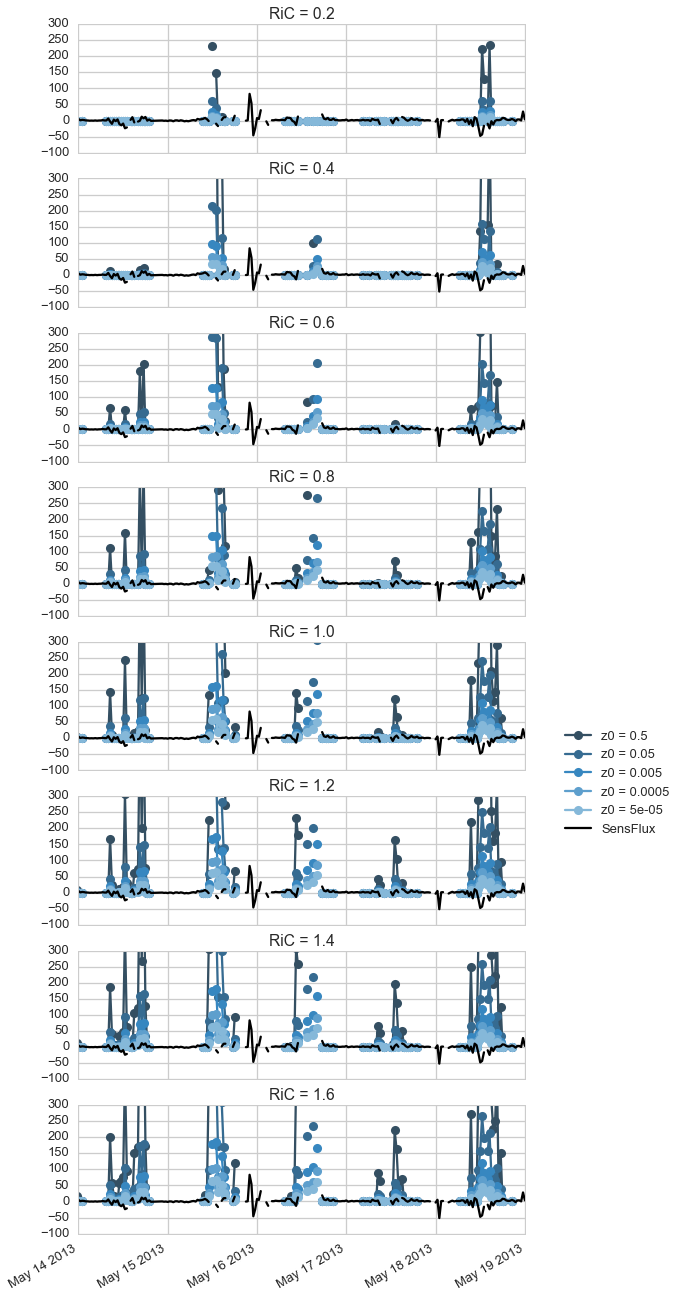

In [24]:
# -------------------------------------------------------------------------------------------------------
# Time Series
colr1 = sns.color_palette('Blues_d', np.size(z0Ground))
fig, axes = plt.subplots(np.size(RiCrit), 1, figsize=(8, 24), sharex=True)
axes = axes.flatten()
sensible_SNQ_plot = sensible_SNQ.reindex_like(SNQ)

for nr, RiC in enumerate(RiCrit):
    ax = axes[nr]
    ax.set_title('RiC = ' + str(RiC))
    for nz, z0 in enumerate(z0Ground):
        ax.plot(sensible_SNQ_plot.time,
                sensible_SNQ_plot[dict(z0=nz, RiC=nr)],
                '-o', color=colr1[nz], label='z0 = ' + str(z0))
    ax.plot(SNQ.time, SNQ.SensFlux, 'k')
    ax.set_ylim(-100, 300)
    ax.set_xlim(datetime(2013, 5, 14, 0, 0, 0), datetime(2013, 5, 19, 0, 0, 0))

lgd = ax.legend(bbox_to_anchor=(1.35, 4))
fig.autofmt_xdate()

## All stable conditions

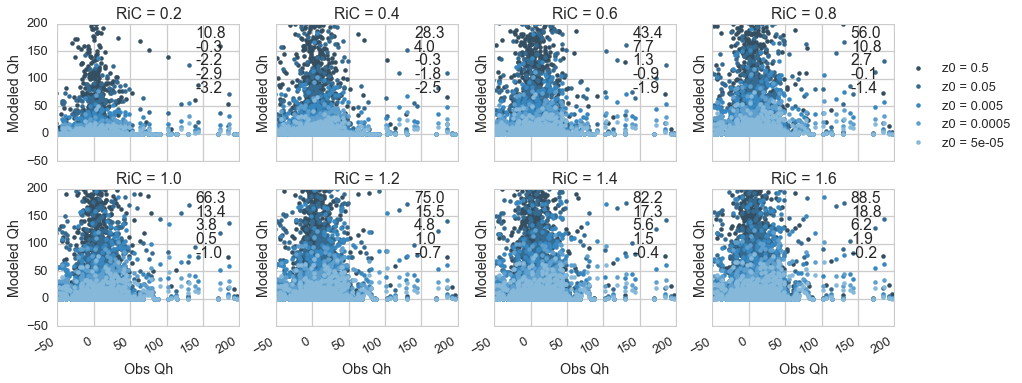

In [26]:
# -------------------------------------------------------------------------------------------------------
# Scatter
fig, axes = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)
axes = axes.flatten()

for nr, RiC in enumerate(RiCrit):
    ax = axes[nr]
    ax.set_title('RiC = ' + str(RiC))
    for nz, z0 in enumerate(z0Ground):
        ax.plot(SNQ.SensFlux[SNQind], sensible_SNQ_plot[dict(z0=nz, RiC=nr)][SNQind],
                '.', color=colr1[nz], label='z0 = ' + str(z0))
        bias = np.mean(sensible_SNQ_plot[dict(z0=nz, RiC=nr)][SNQind] - SNQ.SensFlux[SNQind])
        ax.text(140, 175 - nz * 25, str("%.1f" % bias))
    ax.set_ylim(-50, 200)
    ax.set_xlim(-50, 200)
    ax.set_ylabel('Modeled Qh')
    ax.set_xlabel('Obs Qh')
lgd = ax.legend(bbox_to_anchor=(1.7, 2))
fig.autofmt_xdate()

There are a range of z0 values that produce a small bias, regardless of the critical Richardson number. From this I think I can safely conclude that tuning does not provide us a way forward for improving the performance of $Q_h$. Even more so, this implies that z0 tuning for sensible heat flux is largely a waste of time for the Anderson method.

Ideally I'd like to verify this at SCP, but the amount of computation time that would take is prohibitive.

## Stable and snow present

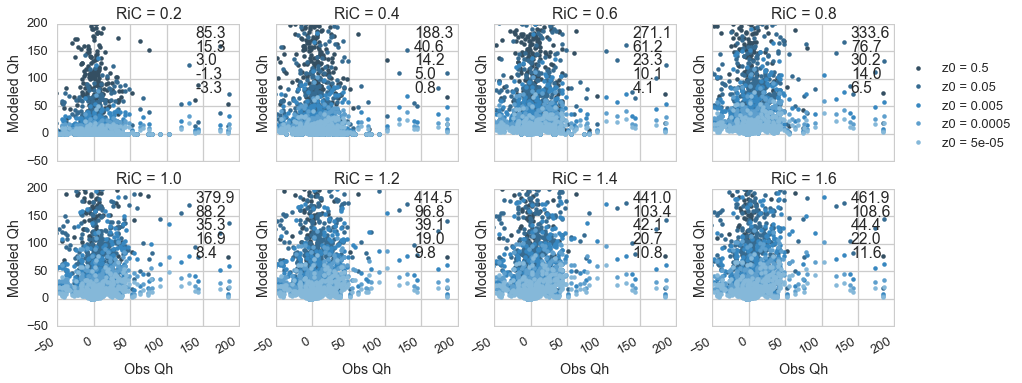

In [27]:
# -------------------------------------------------------------------------------------------------------
# Scatter
fig, axes = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)
axes = axes.flatten()

for nr, RiC in enumerate(RiCrit):
    ax = axes[nr]
    ax.set_title('RiC = ' + str(RiC))
    for nz, z0 in enumerate(z0Ground):
        ax.plot(SNQ.SensFlux[SNQind_SP], sensible_SNQ_plot[dict(z0=nz, RiC=nr)][SNQind_SP],
                '.', color=colr1[nz], label='z0 = ' + str(z0))
        bias = np.mean(sensible_SNQ_plot[dict(z0=nz, RiC=nr)][SNQind_SP] - SNQ.SensFlux[SNQind_SP])
        ax.text(140, 175 - nz * 25, str("%.1f" % bias))
    ax.set_ylim(-50, 200)
    ax.set_xlim(-50, 200)
    ax.set_ylabel('Modeled Qh')
    ax.set_xlabel('Obs Qh')
lgd = ax.legend(bbox_to_anchor=(1.7, 2))
fig.autofmt_xdate()